In [1]:
days_to_check=[30,60,90,120,180] #YOU CAN CHANGE THIS IF YOU WANT TO TRAIN MORE MODELS
# days_to_check=[60,90,120,180] #YOU CAN CHANGE THIS IF YOU WANT TO TRAIN MORE MODELS

# Load Data

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
#LOAD DATA in a DataFrame
bucket='hf-initial-data'
folder_name='processed'
data_key = 'HF_AWS_Final.csv'
data_location = 's3://{}/{}/{}'.format(bucket, folder_name, data_key)

df = pd.read_csv(data_location)

#Enable full print of dataframe just to see everything instead of only 10 columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (188,259,265,289,325,331,346,375,377,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Allotting Imputation Methods

In [3]:
df.dtypes

Unnamed: 0                                                int64
pre_internal_VisitAnonId                                  int64
pre_internal_PatientAnonId                                int64
pre_internal_MrCareProviderAnonId                         int64
pre_internal_MrCareProviderService                       object
pre_internal_Gender                                       int64
pre_internal_Age                                          int64
pre_internal_HealthAuthorityCode                         object
pre_internal_FacilityCode                                object
pre_internal_AdmissionDate                               object
pre_internal_DischargeDate                               object
pre_internal_MRDx                                        object
pre_internal_MR_Unit                                     object
pre_internal_FiscalPeriod                                object
pre_internal_FiscalYear                                   int64
pre_internal_LOS                        

In [4]:
df.drop(df.columns[df.isna().all()],axis=1,inplace=True)
df.isna().all()

Unnamed: 0                                              False
pre_internal_VisitAnonId                                False
pre_internal_PatientAnonId                              False
pre_internal_MrCareProviderAnonId                       False
pre_internal_MrCareProviderService                      False
pre_internal_Gender                                     False
pre_internal_Age                                        False
pre_internal_HealthAuthorityCode                        False
pre_internal_FacilityCode                               False
pre_internal_AdmissionDate                              False
pre_internal_DischargeDate                              False
pre_internal_MRDx                                       False
pre_internal_MR_Unit                                    False
pre_internal_FiscalPeriod                               False
pre_internal_FiscalYear                                 False
pre_internal_LOS                                        False
pre_inte

In [ ]:
impute_info = pd.read_excel('Columns_Missing_Data.xlsx',engine='openpyxl')
cols_to_drop = []
# hx_columns = []
absent_columns = []
miss_zero_columns = []
miss_mean_columns=[]
miss_knn_columns=[]

#assign column names to a particular type of imputation
for i,row in impute_info.iterrows():
    method = row['Suggested Imputation Method']
    #this try-except is because the new columns names have prefixes as opposed to the ones that were labelled by Nat for the 
    #suggested imputation techniques 
    try:
        col = 'pre_internal_' + row['Column Name']
        assert col in df
        print(col,method)
    except:
        try:
            col = 'pre_CSBC_' + row['Column Name']
            assert col in df
            print(col,method)
        except:
            continue

    if method == 'Include' or method =='Missing = 0/None' or method == 'Missing = 0':
        miss_zero_columns.append(col)
    elif method == 'Exclude':
        if df[col].isnull().all():
            cols_to_drop.append(col)
        else:
            miss_mean_columns.append(col)
#         cols_to_drop.append(col)
    elif method == 'Missing = absent':
        absent_columns.append(col)
    elif method == 'Mean':
        miss_mean_columns.append(col)
    elif method == 'Impute':
        miss_knn_columns.append(col)
    else:
        print(col,method)
#         print('Other\n\n\n',col,method,'\n\n\n')





for col in miss_zero_columns:
    df[col] = df[col].fillna(0)
for col in absent_columns:
    if df[absent_columns].dtypes[col]==np.float64:
        print('float column', col)
        df[col] = df[col].fillna(0)
    else:
        print('object column', col)
        df[col] = df[col].fillna('Absent')
print(absent_columns)
df['pre_internal_LabAdm_INR']=df['pre_internal_LabAdm_INR'].fillna(1.0)
df['pre_internal_LabAdm_HbA1C']=df['pre_internal_LabAdm_HbA1C'].fillna(6.0)
df['pre_internal_LabDisch_INR']=df['pre_internal_LabDisch_INR'].fillna(1.0)
df['pre_internal_LabDisch_HbA1C']=df['pre_internal_LabDisch_HbA1C'].fillna(6.0)
df['pre_internal_ECG_Rhythm']=df['pre_internal_ECG_Rhythm'].fillna('Sinus rhythm')
df['pre_internal_ECG_QRS_Morphology']=df['pre_internal_ECG_QRS_Morphology'].fillna('Narrow')
df['pre_internal_ECG_AV_Block']=df['pre_internal_ECG_AV_Block'].fillna('No AV block')
df['pre_internal_Imaging_MR']=df['pre_internal_Imaging_MR'].fillna(0)
df['pre_internal_FollowUpAppointment']=df['pre_internal_FollowUpAppointment'].fillna(0)
# df['ExclusionReason']

# Prepare data for training

In [5]:
bnp=[]
for i,row in df.iterrows():
    t1=row['pre_internal_LabAdm_BNP']
    t2=row['pre_internal_LabAdm_NT_proBNP']
    if not pd.isnull(t1):
        if t1[0]=='<' or t1[0]=='>':
#             print(x)
            t1=t1[1:]
        bnp.append(float(t1))
    elif not pd.isnull(t2):
        if t2[0]=='<' or t2[0]=='>':
#             print(x)
            t2=t2[1:]
        bnp.append(float(t2)/6.25)
    else:
        bnp.append(np.nan)
    print(t1,t2)
    
df['pre_internal_BNP']=bnp
miss_knn_columns.append('pre_internal_BNP')

tp=[]
for i,row in df.iterrows():
    t1=row['pre_internal_LabAdm_TroponinT']
    t2=row['pre_internal_LabAdm_TroponinI']
    if not pd.isnull(t1):
        if t1[0]=='<' or t1[0]=='>':
#             print(x)
            t1=t1[1:]
        tp.append(float(t1))
    elif not pd.isnull(t2):
        if t2[0]=='<' or t2[0]=='>':
#             print(x)
            t2=t2[1:]
        tp.append(float(t2)*1000)
    else:
        tp.append(np.nan)
#     print(t1,t2)
    
df['pre_internal_Troponin']=tp
miss_knn_columns.append('pre_internal_Troponin')

cols_to_drop.extend(['pre_internal_LabAdm_BNP','pre_internal_Death','pre_internal_LabAdm_NT_proBNP','pre_internal_LabAdm_TroponinI','pre_internal_LabAdm_TroponinT','pre_internal_DeathInHospital'])


df.drop(cols_to_drop,axis=1,inplace=True)

# df['ExclusionReason']

pre_internal_ELOS Mean
pre_internal_ALOS_ELOS Mean
pre_internal_Palliative Exclude
pre_internal_hx_CKD Include
pre_internal_hx_COPD Include
pre_internal_hx_Asthma Include
pre_internal_hx_Malignancy Include
pre_internal_hx_LiverDisease Include
pre_internal_hx_Anemia Include
pre_internal_hx_PUD Include
pre_internal_hx_Dementia Include
pre_internal_hx_MI Include
pre_internal_hx_Angina Include
pre_internal_hx_CABG Include
pre_internal_hx_PCI Include
pre_internal_hx_CVA Include
pre_internal_hx_TIA Include
pre_internal_hx_PAD Include
pre_internal_hx_DM Include
pre_internal_hx_HTN Include
pre_internal_hx_Smoking Include
pre_internal_hx_AlcoholExcess Include
pre_internal_hx_AF Include
pre_internal_hx_AFL Include
pre_internal_hx_VTE Include
pre_internal_hx_ExistingHF Include
pre_internal_hx_HF_Hospitalization Include
pre_internal_hx_HeartTransplant Include
pre_internal_Dyspnea Exclude
pre_internal_Orthopnea Exclude
pre_internal_PND Exclude
pre_internal_Swelling Exclude
pre_internal_Fatigue Excl

float column pre_internal_MedDisch_ACEI
object column pre_internal_MedDisch_ACEI_Contraindication
float column pre_internal_MedDisch_ARB
object column pre_internal_MedDisch_ARB_Contraindication
float column pre_internal_MedDisch_BB
object column pre_internal_MedDisch_BB_Contraindication
float column pre_internal_MedDisch_MRA
object column pre_internal_MedDisch_MRA_Contraindication
float column pre_internal_MedDisch_ARNI
object column pre_internal_MedDisch_ARNI_Contraindication
float column pre_internal_MedDisch_DIG
float column pre_internal_MedDisch_Hydralazine
float column pre_internal_MedDisch_NitrateOralOrPatch
float column pre_internal_MedDisch_LoopDiuretic
float column pre_internal_MedDisch_ThiazideDiuretic
float column pre_internal_MedDisch_ASA
float column pre_internal_MedDisch_OtherAntiplatelet
float column pre_internal_MedDisch_Warfarin
object column pre_internal_MedDisch_WarfarinContraindication
float column pre_internal_MedDisch_NOAC
object column pre_internal_MedDisch_NOAC_

nan nan
nan 4602
nan 1180
nan 2370
nan 9044
nan 2283
nan nan
nan nan
nan 2353
nan 2810
nan 7781
nan nan
nan 7203
1583 nan
nan nan
nan 2079
nan 814
nan nan
nan 7262
nan 7471
nan nan
nan 19469
nan 1977
nan nan
nan 25102
nan 1578
1978 nan
nan 7668
5000 nan
nan nan
nan 33888
nan 4846
nan nan
nan nan
nan nan
nan nan
nan 994
2273 nan
152 nan
nan 1789
nan nan
nan 4801
nan 2297
nan 2055
nan nan
nan 25318
nan 6481
nan 7069
nan nan
nan nan
nan 6868
nan nan
nan nan
nan 1872
5000 nan
551 nan
nan 22683
nan 2704
nan 1641
nan 655
nan 3928
381 nan
943 nan
nan 4281
nan nan
1225 nan
nan nan
nan 6658
255 nan
nan 3609
nan nan
1186 nan
nan 21359
nan 18227
nan 2122
nan 2925
2647 nan
1319 nan
nan 21978
nan nan
nan nan
nan nan
nan nan
nan 770
nan 38645
nan 2673
1549 nan
nan nan
3249 nan
nan nan
nan 5612
nan 6075
nan 1474
nan nan
nan nan
nan nan
nan 4438
nan 8370
nan nan
nan 10863
207 nan
1137 nan
nan 4128
nan nan
nan nan
nan nan
nan 2285
nan nan
nan 13978
nan nan
272 nan
nan 4478
nan 8507
nan nan
nan nan
nan 

In [6]:
import datetime


for hosp in range(1,55,1):
    adm_day=[]
    adm_month=[]
    discharge_day=[]
    discharge_month=[]
    for i,row in df.iterrows():
        date = row['post_ADMISSION_DATE_'+str(hosp)]
        if pd.isnull(date):
            adm_day.append(np.nan)
            adm_month.append(np.nan)
            discharge_day.append(np.nan)
            discharge_month.append(np.nan)
        else:
#         print(date)
            at=datetime.datetime.strptime(date,'%Y-%m-%d')
            adm_day.append(at.weekday())
            adm_month.append(at.month)

            dt=datetime.datetime.strptime(date,'%Y-%m-%d') + datetime.timedelta(days=row['post_LOS_'+str(hosp)])
            discharge_day.append(dt.weekday())
            discharge_month.append(dt.month)
    df['post_ADMISSION_DATE_DAY_'+str(hosp)]=adm_day
    df['post_ADMISSION_DATE_MONTH_'+str(hosp)]=adm_month

    df['post_Discharge_Day_'+str(hosp)]=discharge_day
    df['post_Discharge_Month_'+str(hosp)]=discharge_month

In [7]:
#cap hospitalizations at 5 for regression models. 
#Not used in classification models as we predict re-hospitalization within N days and not the number of hospitliazations
def cap(l,n=5.0):
    r=[]
    for x in l:
        if x>n:
            r.append(n)
        else:
            r.append(x)
    return r
# df_not_missing['HospitalizationCountCapped']=cap(df_not_missing['HospitalizationCount'])
df['post_n_rehosp_cap']=cap(df['post_n_rehosp'])




# print(list(df.columns))
t_death = []
for i,row in df.iterrows():
    if not pd.isna(row['post_Death_date']):
        hosp = int(row['post_n_rehosp'])
        disch_date = row['pre_internal_DischargeDate']
#         print(hosp)
        dt=datetime.datetime.strptime(disch_date,'%Y-%m-%d')
        t = datetime.datetime.strptime(row['post_Death_date'],'%m/%d/%Y') - dt
        t=t.days
    else:
        t = np.inf
    t_death.append(t)
df['post_Time_to_death']=t_death
# for d in days_to_check:
#     df['Death_'+d]=df[]
# print(df['Timehttps://hf-data-analysis.notebook.ca-central-1.sagemaker.aws/notebooks/Train_Hospitalization_Classifier.ipynb#_to_death'])


for d in days_to_check:
    df[('post_Death_'+str(d))]=(df['post_Time_to_death']<=d).astype(int)

# print(df['Death_30'])

t_rehosp=[]

for i,row in df.iterrows():
    if not pd.isna(row['post_ADMISSION_DATE_1']):
        hosp = int(row['post_n_rehosp'])
        disch_date = row['pre_internal_DischargeDate']
#         print(hosp)
        dt=datetime.datetime.strptime(disch_date,'%Y-%m-%d')
        t = datetime.datetime.strptime(row['post_ADMISSION_DATE_1'],'%Y-%m-%d') - dt
        t=t.days
    else:
        t=np.inf
    t_rehosp.append(t)
df['post_days_for_first_rehosp']=t_rehosp
# for d in days_to_check:
#     df['Death_'+d]=df[]
# print(df['Time_to_death'])

for d in days_to_check:
    df[('post_Hospitalization_'+str(d))]=(df['post_days_for_first_rehosp']<=d).astype(int)

for d in days_to_check:
    df[('post_Risk_'+str(d))]=((df[('post_Hospitalization_'+str(d))])|(df['post_Death_'+str(d)])).astype(int)

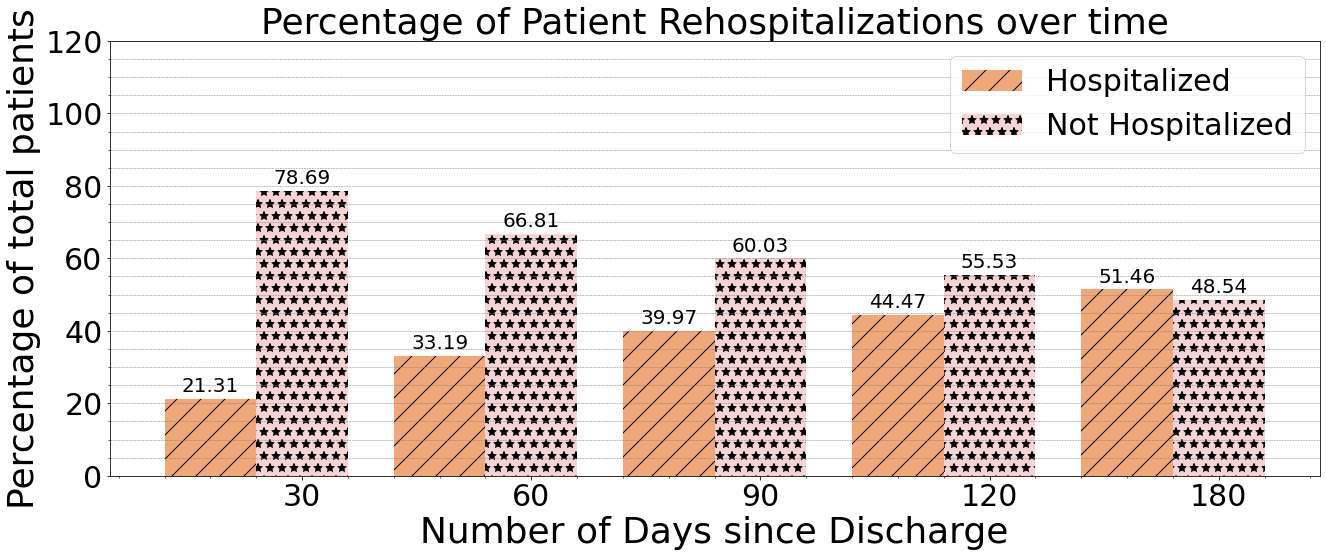

In [8]:
def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
#             print(rect)
#             print(rect.get_x() + rect.get_width() / 2, height)
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',fontsize=20)

p1=[]

total_data=len(df)

for d in days_to_check:
    p1.append(np.round((df[('post_Hospitalization_'+str(d))].sum()/total_data)*100,2))

p1c=np.round([100.00-x for x in p1],2)

    

plt.rcParams["figure.figsize"] = (18,7)
fig, ax = plt.subplots()
x = np.arange(1,len(days_to_check)+1,1)  # the label locations
width=0.4
bar_width=0.4
rects1 = ax.bar(x-width, p1, bar_width, label='Hospitalized',color='#F1A879',hatch='/')
rects2 = ax.bar(x , p1c, bar_width, label='Not Hospitalized',color='#F4D4D4',hatch='*')

autolabel(rects1)
autolabel(rects2)

ax.legend(fontsize=30,loc='upper right')

ax.set_ylim([0,120])
plt.yticks(fontsize=30)
plt.xticks(ticks=x,labels = [x for x in days_to_check],fontsize=30)
# plt.set_xlabel([x/30 for x in days_to_check])
fig.tight_layout()
ax.set_ylabel('Percentage of total patients',fontsize=36)
ax.set_xlabel('Number of Days since Discharge',fontsize=36)
plt.title('Percentage of Patient Rehospitalizations over time',fontsize=36)
plt.grid(which='both',axis='y',color='gray', linestyle='--', linewidth=.5)
plt.minorticks_on()
plt.show()

# Begin Training Models

In [9]:
%pip install imbalanced-learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import export_graphviz

from copy import deepcopy

print(df.shape)
cat_columns = list(df.select_dtypes(include=['object']).columns)#select those columns which are of 'object' type
df_factorized=deepcopy(df)
df_factorized[cat_columns] = df_factorized[cat_columns].apply(lambda x: pd.factorize(x)[0])
# df_not_missing = df_not_missing.drop(['CreateDate','AdmissionDate','DischargeDate','PatientAnonId','Unnamed: 0'],axis=1)
print(df.shape)

#drop 'unnamed' columns that happen due to pandas merging
df_factorized.drop(df.filter(regex="Unname"),axis=1, inplace=True)
#drop RefLimit columns as there is not enough data for them
df_factorized.drop(df.filter(regex="RefLimit"),axis=1, inplace=True)
print(df_factorized.dtypes)

#drop some columns to be imputed since we dropped them
miss_duplicate_mean_columns=[c for c in miss_mean_columns if c in list(df_factorized.columns)]
miss_mean_columns=miss_duplicate_mean_columns

# print(df_factorized.dtypes)
# print(df_factorized['MedDisch_NSAID'])

Note: you may need to restart the kernel to use updated packages.
(1844, 908)
(1844, 908)
pre_internal_VisitAnonId                                  int64
pre_internal_PatientAnonId                                int64
pre_internal_MrCareProviderAnonId                         int64
pre_internal_MrCareProviderService                        int64
pre_internal_Gender                                       int64
pre_internal_Age                                          int64
pre_internal_HealthAuthorityCode                          int64
pre_internal_FacilityCode                                 int64
pre_internal_AdmissionDate                                int64
pre_internal_DischargeDate                                int64
pre_internal_MRDx                                         int64
pre_internal_MR_Unit                                      int64
pre_internal_FiscalPeriod                                 int64
pre_internal_FiscalYear                                   int64
pre_internal_L

In [10]:
# %pip install shap
import shap # v0.40.0
# shap.initjs()
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance
def model_train(m,parameters,is_tree=False,is_rf=False,time=None):
    
    y = df[('post_Hospitalization_'+str(time))].values
    x_data = df_factorized.drop(df_factorized.filter(regex="post"),axis=1)
    #x = (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data)).values
#     print("inf columns ", x_data.columns.to_series()[np.isinf(x_data).any()])
#     print('null columns ', x_data.isna().sum())
    x = x_data
    
    #output of this function
    cf=[]
    
    #feature importances
    fis=[]
    
    #3 runs of cross-validation
    for rs in [1,2,3]:
        #8-fold cross validation
        skf = StratifiedKFold(n_splits=8,shuffle=True,random_state=rs)
        skf.get_n_splits(x, y)
        for train_index, test_index in skf.split(np.zeros(x.shape[0]), y):
            print(train_index)
            x_train, x_test = x.iloc[train_index,:], x.iloc[test_index,:]
            y_train, y_test = y[train_index], y[test_index]


            #
            empty_train_columns =  []
            for col in x_train.columns.values:
                # all the values for this feature are null
                if sum(x_train[col].isnull()) == x_train.shape[0]:
                    empty_train_columns.append(col)
            imputed_train_columns=[c for c in x_train.columns if c not in empty_train_columns]
    #         x_train = x_train.dropna(axis=1,how='all').values
    
#             empty_test_columns =  []
#             for col in x_test.columns.values:
#                 # all the values for this feature are null
#                 if sum(x_test[col].isnull()) == x_test.shape[0]:
#                     empty_test_columns.append(col)
#             imputed_test_columns=[c for c in x_test.columns if c not in empty_test_columns]
            
            print('empty training columns - ', empty_train_columns)
#             print(empty_test_columns)
            #impute missing
            imp_knn = KNNImputer(missing_values=np.nan)
            
            

            imp_knn_x_train=pd.DataFrame(imp_knn.fit_transform(x_train),index=x_train.index,columns=imputed_train_columns)
            imp_knn_x_test=pd.DataFrame(imp_knn.transform(x_test),index=x_test.index,columns=imputed_train_columns)

            imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')

            imp_mean_x_train=pd.DataFrame(imp_mean.fit_transform(x_train),index=x_train.index,columns=imputed_train_columns)
            imp_mean_x_test=pd.DataFrame(imp_mean.transform(x_test),index=x_test.index,columns=imputed_train_columns)

    #         print("Imputated training data - iron lvl",imp_knn_x_train['LabAdm_Iron'])
    #         print(x_train['LabAdm_Iron'])
    #         print(imp_mean_x_train.shape)

            for col in miss_knn_columns:
                x_train[col]=imp_knn_x_train[col]
                x_test[col]=imp_knn_x_test[col]
                
                #check if there are null values after imputing. should ideally not run
                if pd.isnull(x_train[col]).sum() > 0:
                    print(col,x_train.shape)
                    print('Null values for col, ',col,' are',pd.isnull(x_train[col]).sum())
                    print(x_train[col])
            for col in miss_mean_columns:
                x_train[col]=imp_mean_x_train[col]
                x_test[col]=imp_mean_x_test[col]
    #         print(x_train.shape)
    #         print(pd.isnull(x_train).sum())
    #         print(pd.isnull(imp_mean_x_train).sum())

        #smote
            over = SMOTE()
            under = RandomUnderSampler()
            steps = [('o', over),('u',under)]
            pipeline = Pipeline(steps=steps)
#             print(x_train.isna().sum())
            x_train, y_train = pipeline.fit_resample(x_train, y_train)

        #model fit and prediction
        #create model
            model = clone(m)
        #fit

            clf = GridSearchCV(model, parameters,cv=5, n_jobs=4)
            clf.fit(x_train, y_train)


            model = clf.best_estimator_
            
    #         #shap feature importance - runs too slow so it is commented out
    #         import shap
    #         explainer = shap.KernelExplainer(model.predict,x_train)
    #         shap_test = explainer.shap_values(x_test,n_samples=1000)
    #         print(f"Shap values length: {len(shap_test)}\n")
    #         print(f"Sample shap value:\n{shap_test[0]}")
    #         shap_df = pd.DataFrame(shap_test.values, 
    #                        columns=shap_test.feature_names, 
    #                        index=x_test.index)
    #         print(np.isclose(model.predict(x_test), explainer.expected_value[0] + shap_df.sum(axis=1)))

    #         columns = shap_df.apply(np.abs).mean()\
    #                          .sort_values(ascending=False).index
    #         fig, ax = plt.subplots(1, 2, figsize=(11,4))
    #         sns.barplot(data=shap_df[columns].apply(np.abs), orient='h', 
    #                     ax=ax[0])
    #         ax[0].set_title("Mean absolute shap value")
    #         sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
    #         ax[1].set_title("Distribution of shap values");
    #         plt.show()

            result = permutation_importance(model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
            feature_importances = pd.DataFrame(result.importances_mean, index =x_test.columns,  columns=['importance']).sort_values('importance', ascending=False)

            print(feature_importances.head(20))
            fis.append(feature_importances)
    #         sorted_idx = result.importances_mean.argsort()
    #         fig, ax = plt.subplots()
    #         ax.boxplot(
    #             result.importances[sorted_idx].T, vert=False, labels=x_test.columns[sorted_idx]
    #         )
    #         ax.set_title("Permutation Importances (test set)")
    #         fig.tight_layout()
    #         plt.show()
    #     check common entries between x_train and x_test
    #         crs=[]
    #         print('common rows')
    #         for row in x_test:
    # #             print(row)
    #             cr = np.where((x_train == row).all(axis=1))
    #             if len(cr)>0:
    #                 crs.append(cr)
    # #             print(cr[0])
    # #             print(x_train[cr[0]])
    #         print(crs)

        #check duplicates for x_train
    #         num_dups=(x_train[:, np.newaxis] == x_train).all(axis=2).sum(axis=1)
    #         print('Duplicates ' ,np.where((num_dups>1)))

        #predict
            y_pred = clf.predict(x_test)
            matrix=confusion_matrix(y_test,y_pred)
            cf.append(matrix)
            print('Best params')
            print(clf.best_estimator_.get_params())
            print("Accuracy: ",(np.trace(matrix))/matrix.sum()*100)
    df_concat = pd.concat(fis)
    print(df_concat.groupby(level=0).mean().sort_values('importance', ascending=False))
    cf.append(df_concat.groupby(level=0).mean().sort_values('importance', ascending=False))
    return cf


def output_metrics(matrices,fis):
    average_matrix=np.mean(matrices,axis=0)
    class_accs = []
    ov_accs=[]
    for matrix in matrices:
        c = []
        ov_acc = (np.trace(matrix))/matrix.sum()*100
        ov_accs.append(ov_acc)
        for i in range(2):
            c.append((matrix[i][i]/matrix[i].sum()*100))
        class_accs.append(c)
    class_acc=np.mean(class_accs,axis=0)
    ov_accs=np.mean(ov_accs,axis=0)
    print("Overall Accuracy :",ov_accs)
    print("Class Accuracy for No Hospitalizations",class_acc[0])
    print("Class Accuracy for Hospitalizations",class_acc[1])
    print('Feature Importances',fis.head(10))
    return([matrices,fis,ov_accs,class_acc[0],class_acc[1]])

def c_thresholds(fold_tests,fold_preds,t=0.5):
    matrices=[]
    print('fp length', len(fold_preds))
    for fold_ind in range(len(fold_tests)):
        fold_pred=fold_preds[fold_ind]
        fold_test=fold_tests[fold_ind]
        fp=[]
        for pred in fold_pred:
            print(pred[0]/pred.sum())
            if pred[0]/pred.sum() >= t:
                fp.append(0)
            else:
                fp.append(1)
        matrices.append(confusion_matrix(fold_test,fp))
#         print(fold_pred)
    return matrices



In [11]:
#Create an empty dataframe for training

# print(days_to_check)



time_graphs={}
for d in days_to_check:
    time_graphs[d]={}



### dummy classifier / baseline

In [12]:
# from sklearn.dummy import DummyClassifier
# parameters={}
# for d in days_to_check:
#     m = model_train(DummyClassifier(strategy="stratified"),parameters,time=d)
#     matrices=m[:-1]
#     fis=m[-1]
#     time_graphs[d]['Baseline']=output_metrics(matrices,fis)
#     with open('results/'+'Baseline'+'_'+str(d)+'_hospitalization_classifier_final.pkl', 'wb') as file:
#         # A new file will be created
#         pickle.dump(time_graphs[d]['Baseline'], file)

### Gaussian Naive Bayes Model

In [13]:
# from sklearn.naive_bayes import GaussianNB
# parameters = {'var_smoothing': np.logspace(0,-9, num=100)}
# for d in days_to_check:
#     m = model_train(GaussianNB(),parameters,time=d)
#     matrices=m[:-1]
#     fis=m[-1]
#     time_graphs[d]['GNB']=output_metrics(matrices,fis)
# #     print(output_metrics(matrices,fis))
#     with open('results/'+'GNB'+'_'+str(d)+'_hospitalization_classifier_final.pkl', 'wb') as file:
#         # A new file will be created
#         pickle.dump(time_graphs[d]['GNB'], file)

### K-Nearest Neighbors Classifier

In [14]:
# from sklearn.neighbors import KNeighborsClassifier
# parameters={'n_neighbors':[2,3,4,5,10]}
# for d in days_to_check:
#     m = model_train(KNeighborsClassifier(),parameters,time=d)
#     matrices=m[:-1]
#     fis=m[-1]
#     time_graphs[d]['KNN']=output_metrics(matrices,fis)
#     with open('results/'+'KNN'+'_'+str(d)+'_hospitalization_classifier_final.pkl', 'wb') as file:
#         # A new file will be created
#         pickle.dump(time_graphs[d]['KNN'], file)

### Random Forest Classifier

In [15]:
# from sklearn.ensemble import RandomForestClassifier
# parameters = {'max_depth':[1,5,10],
#               'n_estimators': [10,50,100],
#               'max_features': [1,3,5,'auto']
#              }
# for d in days_to_check:
#     m = model_train(RandomForestClassifier(),parameters,time=d)
#     matrices=m[:-1]
#     fis=m[-1]
#     time_graphs[d]['RF']=output_metrics(matrices,fis)
#     with open('results/'+'RF'+'_'+str(d)+'_hospitalization_classifier_final.pkl', 'wb') as file:
#         # A new file will be created
#         pickle.dump(time_graphs[d]['RF'], file)